# Gaussian Process Regression model for analyzing diffraction data

* Input: diffraction patterns taken from "xdr" files 
* Output: composition profiles taken from "xy" files

### GPR:

Composition profile at each point (distance) $d_i$ is approximated by:
$$ C_i(\tilde{D}) = \sum_j \omega_j^i k_\sigma(\tilde{D},D)$$
where $D$ and $\tilde{D}$ are two diffraction patterns, $K(\tilde{D},D)$ is the kernel which measures
the similarity between $D$ and $\tilde{D}$, $\{\omega\}$ is the set of weights to
be optimized, and $i$ is the distance grid point index: $d_i = i\Delta d$ ($\Delta d$ is the
spacing between gridpoints).

Optimized weights are given by:

$$ \boldsymbol{\omega}^i = \left( \mathbf{K}_\sigma + \alpha \mathbf{I}\right)^{-1} \mathbf{C}_i$$

where $\boldsymbol{\omega}^i$ and $\mathbf{C}_i$ are vectors containing weights and known compositions
for each training sample, $\alpha$ is an adjustable
parameter, and $\mathbf{K}_\sigma$ is the kernel (covariance) matrix. We start with the 
most commonly used Gaussian kernel function and will try several other kernels as well.

* Gaussian (or RBF) kernel: 
$$K_\sigma(D^i,D^j) = \exp \left(-\frac{\sum_k || D^i_k - D^j_k||^2}{2\sigma^2}\right)$$
where $|| \cdots ||$ is some distance metric and $\sigma$ controls the width of a Gaussian 
and is another adjustable parameter. 
Since $D$ is a 1D array of intensities we 
take $|| \cdots ||$ to be just the difference between
two points of $D^i$ and $D^j$.


/anaconda2/envs/deeplearning/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.15137256]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


<IPython.core.display.Javascript object>


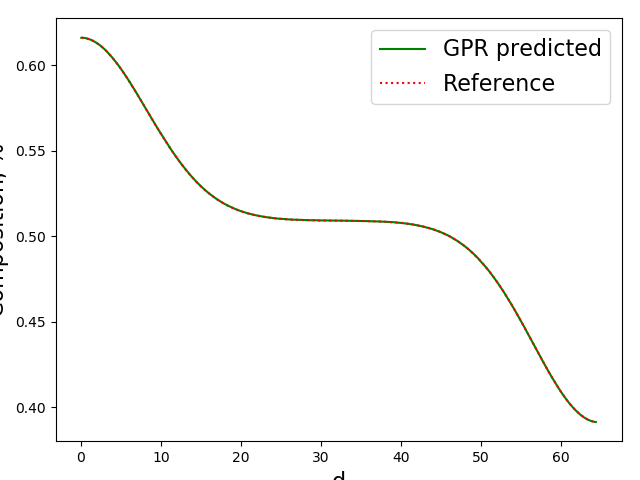

<IPython.core.display.Javascript object>


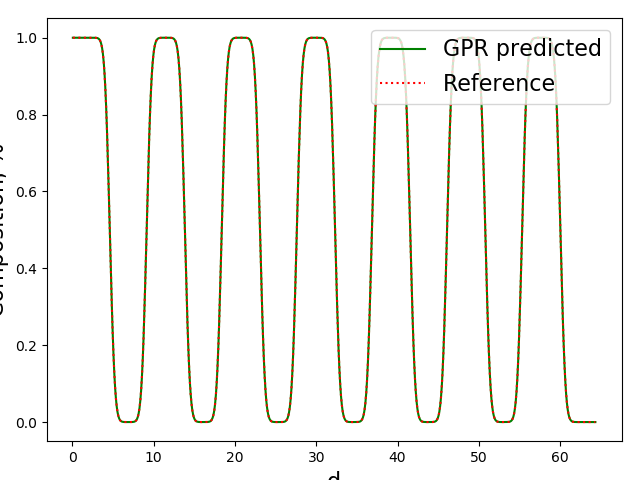

<IPython.core.display.Javascript object>


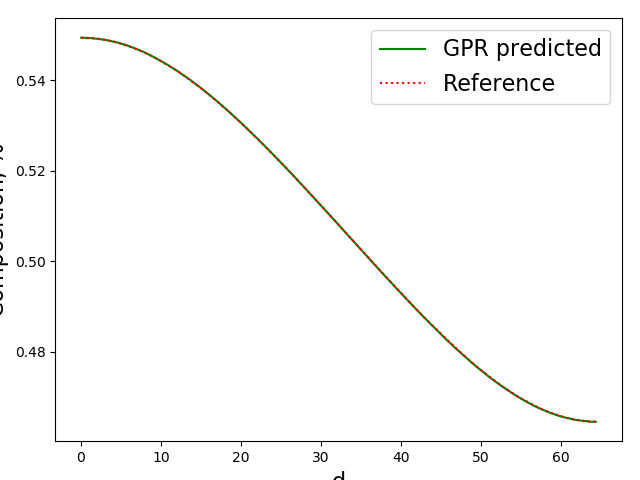

<IPython.core.display.Javascript object>


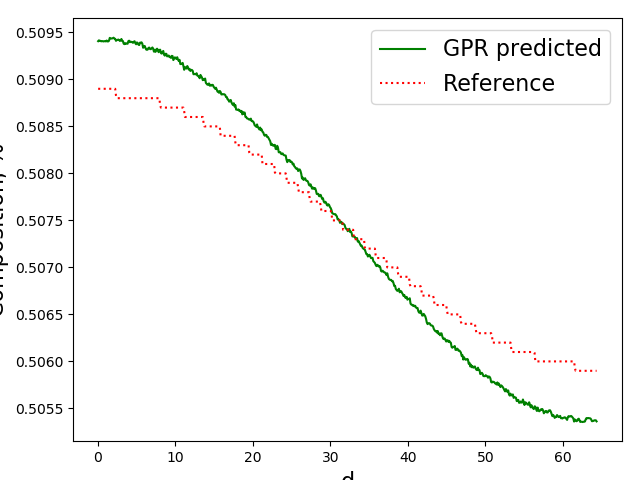

<IPython.core.display.Javascript object>


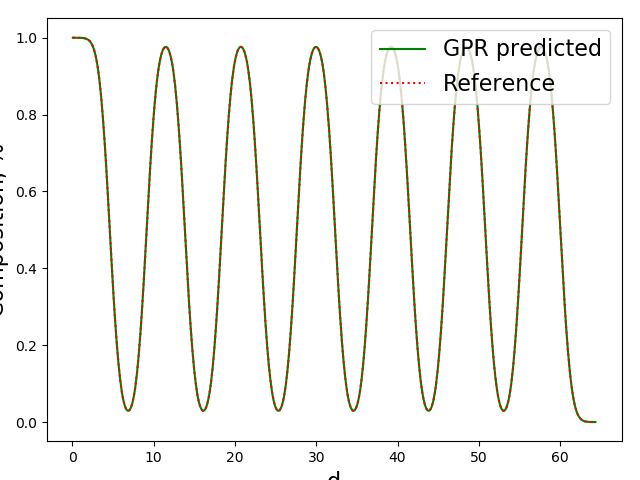

<IPython.core.display.Javascript object>


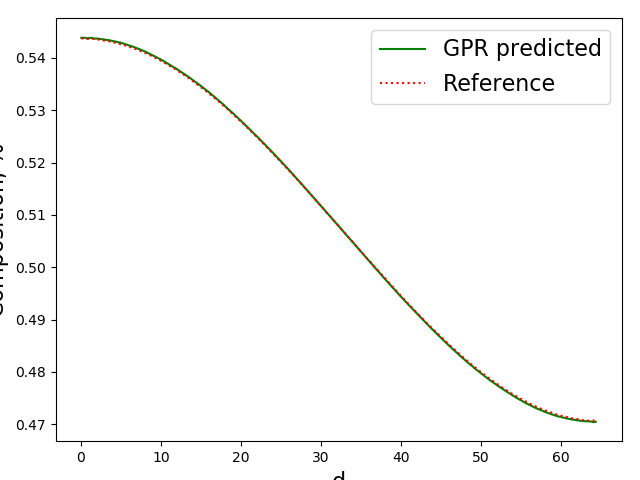

<IPython.core.display.Javascript object>


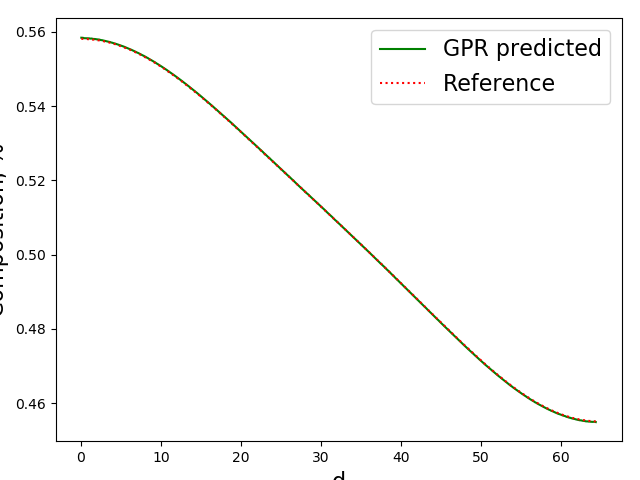

<IPython.core.display.Javascript object>


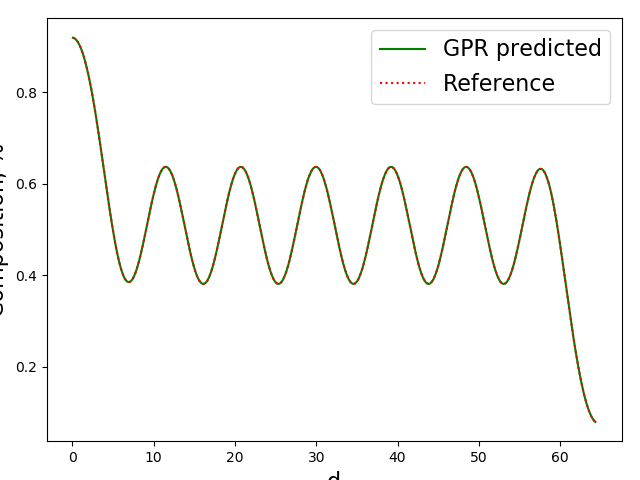

<IPython.core.display.Javascript object>


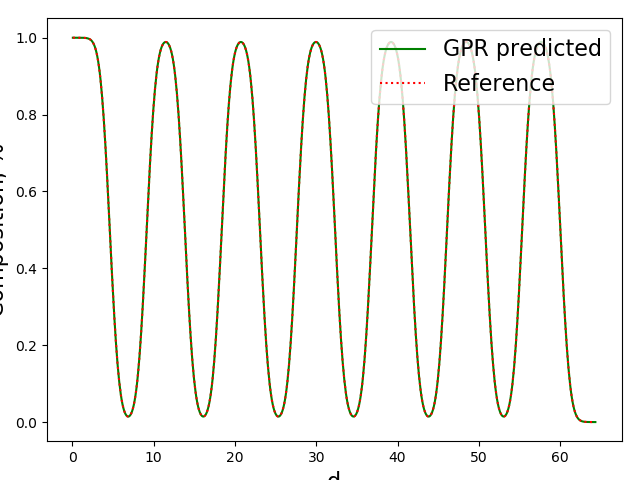

<IPython.core.display.Javascript object>


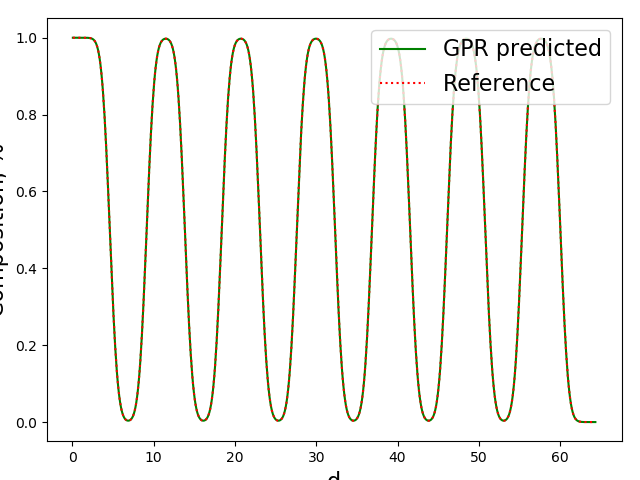

/anaconda2/envs/deeplearning/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


<IPython.core.display.Javascript object>


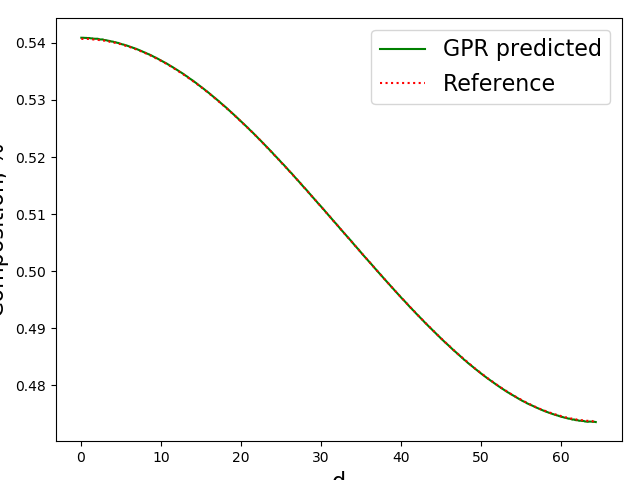

<IPython.core.display.Javascript object>


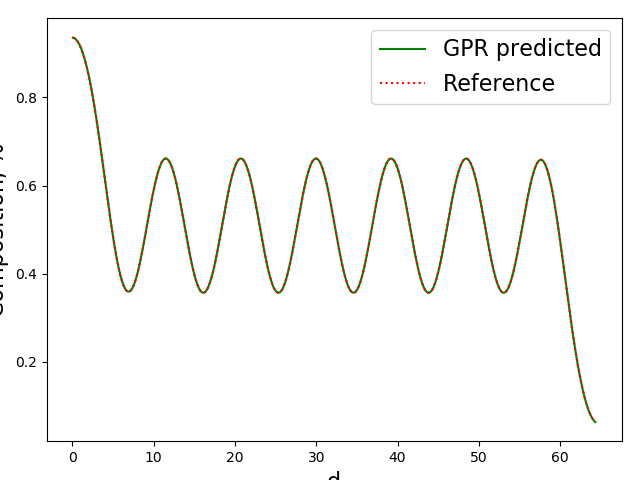

<IPython.core.display.Javascript object>


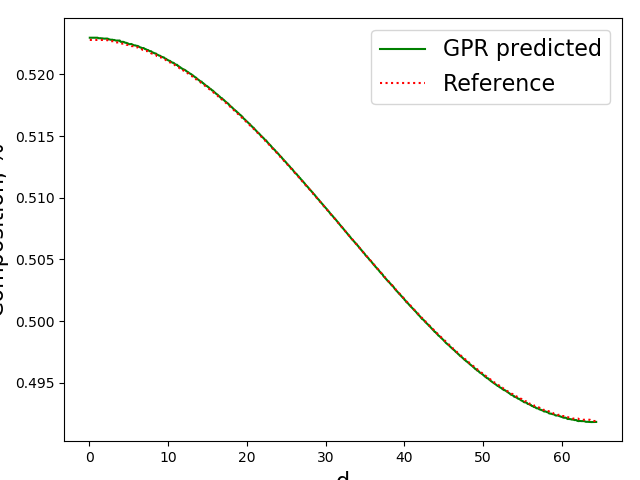

<IPython.core.display.Javascript object>


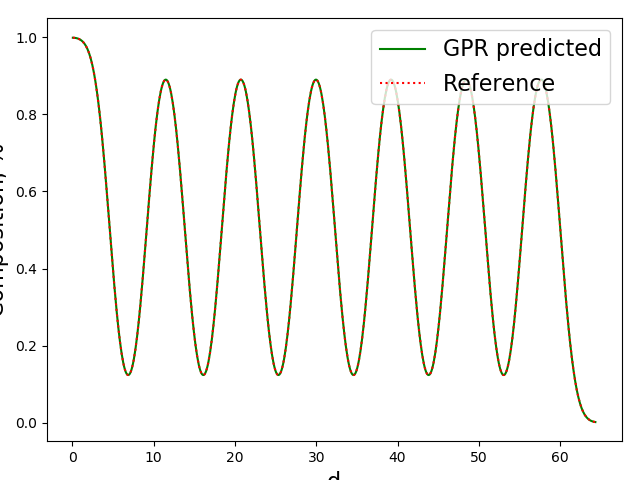

<IPython.core.display.Javascript object>


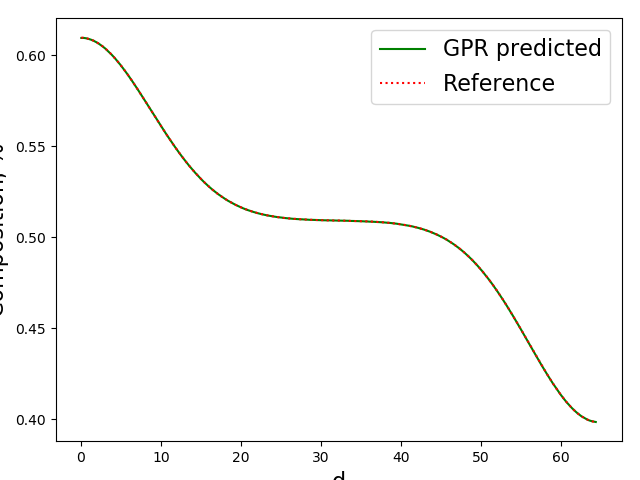

<IPython.core.display.Javascript object>


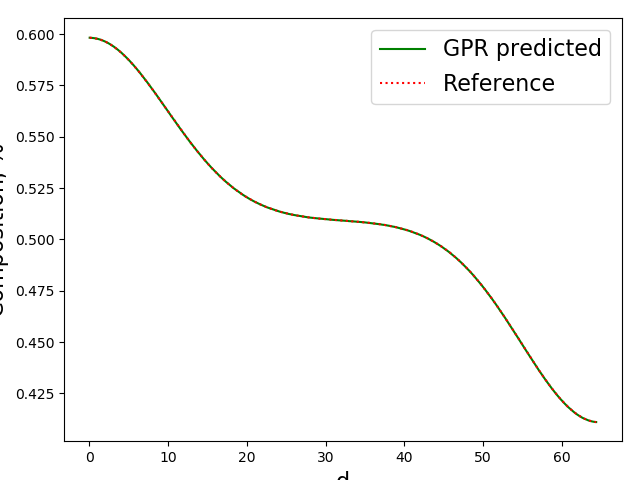

<IPython.core.display.Javascript object>


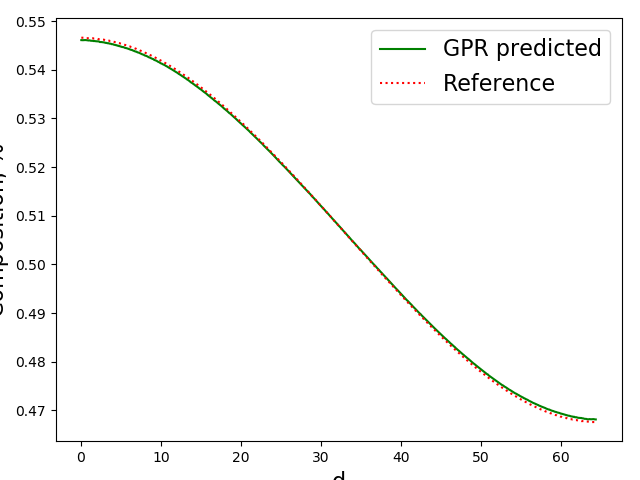

<IPython.core.display.Javascript object>


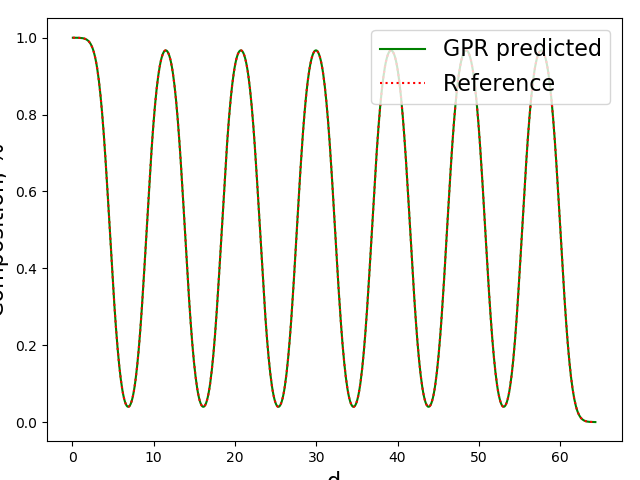

<IPython.core.display.Javascript object>


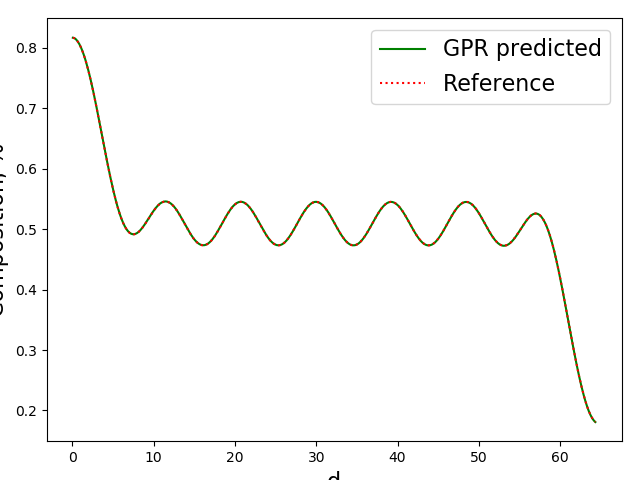

<IPython.core.display.Javascript object>


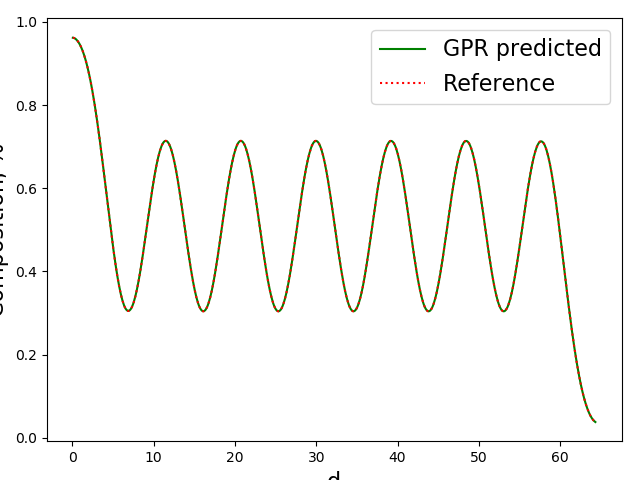

/anaconda2/envs/deeplearning/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


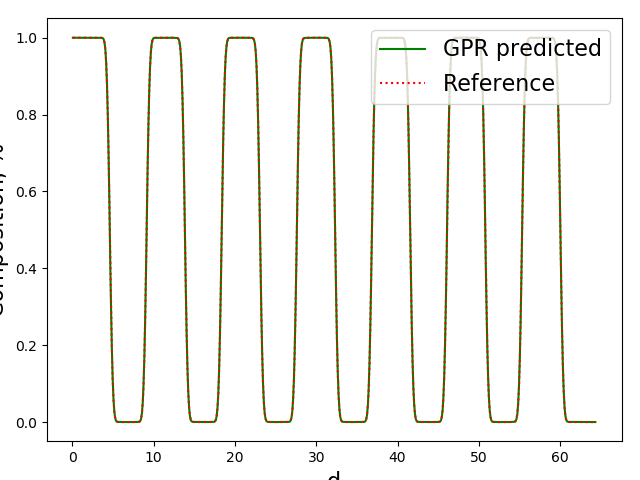

<IPython.core.display.Javascript object>


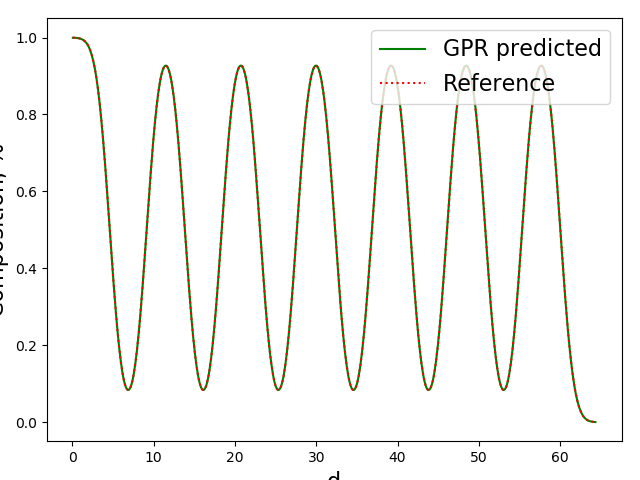

<IPython.core.display.Javascript object>


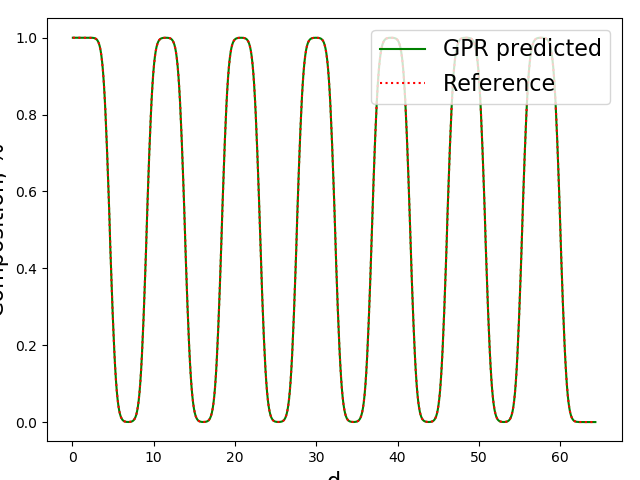

<IPython.core.display.Javascript object>


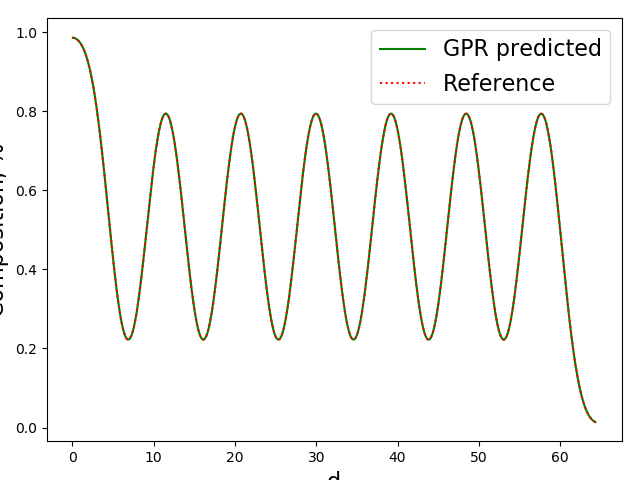

<IPython.core.display.Javascript object>


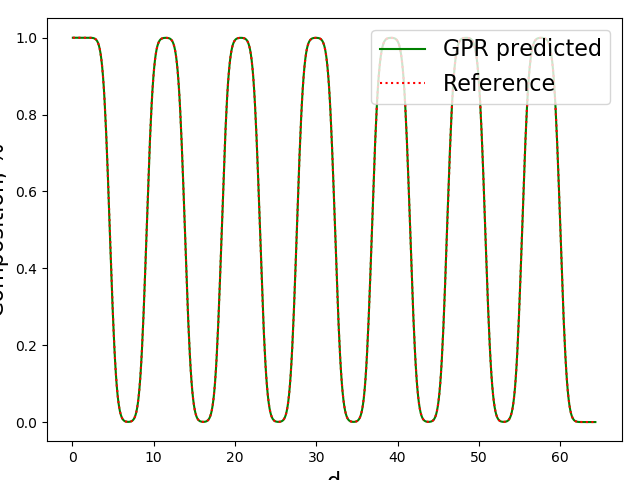

<IPython.core.display.Javascript object>


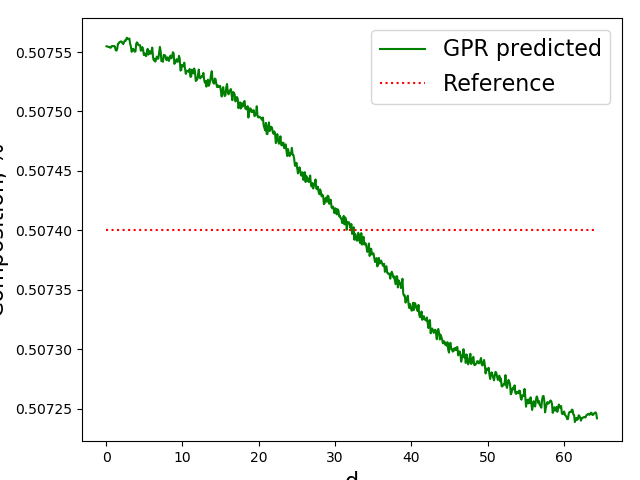

<IPython.core.display.Javascript object>


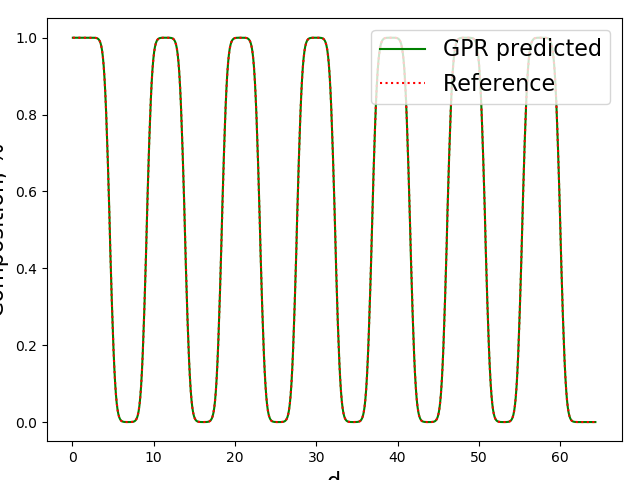

<IPython.core.display.Javascript object>


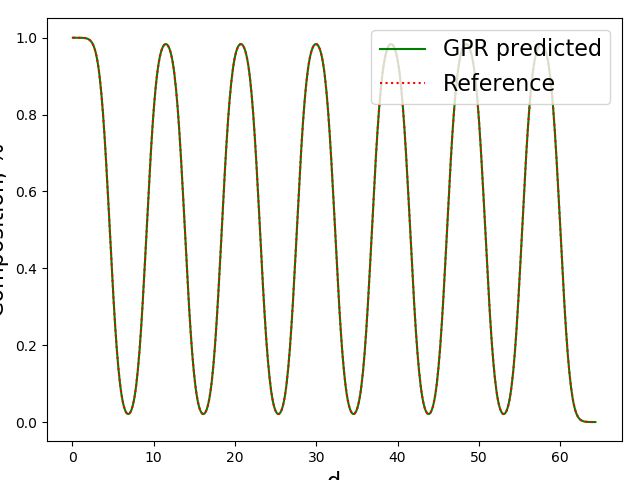

<IPython.core.display.Javascript object>


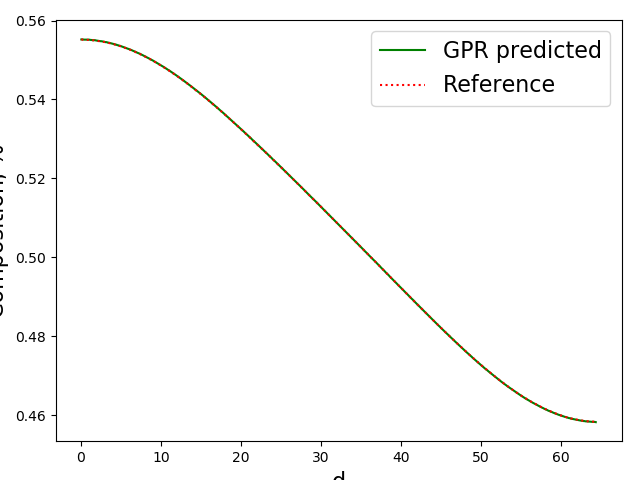

<IPython.core.display.Javascript object>


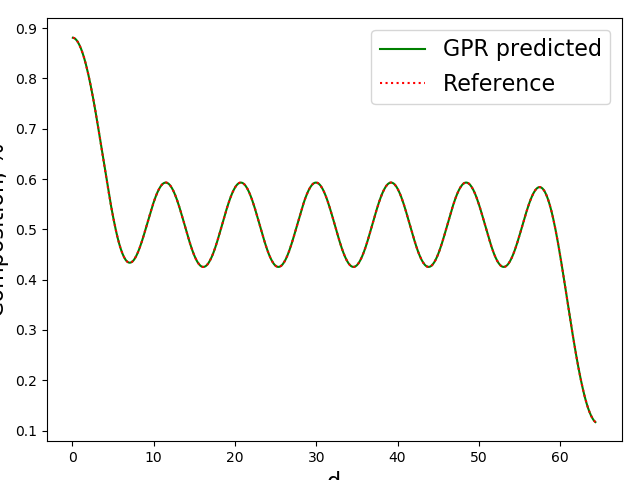

<IPython.core.display.Javascript object>


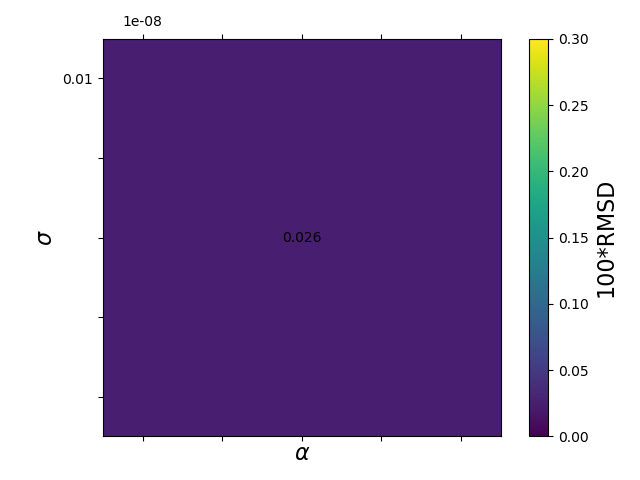

In [89]:
alphas  = [1e-8] #np.logspace(-10,2,13,True)
sigmas  = [0.01] #np.logspace(-5,2,8,True)

errors = np.zeros((len(sigmas), len(alphas)))

for l, alpha in enumerate(alphas):
    for s, sigma in enumerate(sigmas):
        errors[s,l] = run(sigma, alpha)
        
plot_data(alphas, sigmas, errors)

In [85]:
import numpy as np
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern)

def run(sigma, alpha):
    """
       Main routine:
       since we don't have a lot of data we perform k-fold cross validation
       and average errors of each run
    
    """
    Ndata  = 102
    Ntrain = 92
    Ntest  = Ndata - Ntrain
    n_cross_valid = 3
    
    cv_errors = np.zeros((n_cross_valid))
    errors = np.zeros((Ntest))
    
    qgrid, ints, xgrid_raw, comp_raw, xgrid, comp = load_data() 
    
    inds = np.arange(Ndata)
    np.random.shuffle(inds)   
    
    kernel = RBF(length_scale=sigma, length_scale_bounds=(1e-2, 1e2))
    #kernel = Matern(length_scale=sigma, length_scale_bounds=(1e-2, 1e2), nu=1.5)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=10)
    
    for k in range(n_cross_valid):
        x_train, x_test, y_train, y_test = train_test_split(ints, comp, Ntrain, Ntest, k, n_cross_valid, inds)
    
        gp.fit(x_train, y_train)
        y_pred, sigma = gp.predict(x_test, return_std=True)
        
        errors[:] = 0.0
        for m in range(Ntest): 
            errors[m] = np.sqrt(np.mean((y_pred[m,:]-y_test[m,:])**2))
            plot_compare(xgrid, y_pred[m,:], xgrid, y_test[m,:], "GPR predicted", "Reference", m, k)
        
        cv_errors[k] = np.mean(errors)
    
    return np.mean(cv_errors)

# Reading data here

* We focus on a range of Q=[25,29] and Q=[51,58] where the two sets of peaks are located.
This allows us to reduce the size of the input vector to 1100 intensity values.

* Scaling factor just scales the intensity (it is probably not needed, just feels better to deal with numbers on the order of 1).


## Composition profiles
First read each line in each file which is 2750 lines per file for x3 files, 4598 for x5 and, 6446 for x7 files. 
It sounds like too many so we will set a coarser resolution but make it adjustable. Right now we set the new
resolution to be 0.1 instead of native 0.01. Results are good with the new resolution.

### TO DO LIST:

<input type="checkbox"> Try original resolution of 0.01

In [79]:
def load_data():
    
    datadir = "../../data/AuPtSL20x20x7/"
    ndata = 102
    scaling_factor = 1e7
    
    # Q grid is only needed if we want to plot diffraction
    # pattern, it is not used in the GPR model
    # take low Q features with Q=[25,29]
    # and high Q features with Q=[51,58]
    qminL = 25.0
    qmaxL = 29.0
    qminH = 51.0
    qmaxH = 58.0
    dq = 0.01
    
    NQgridL = int((qmaxL - qminL)/dq)
    NQgridH = int((qmaxH - qminH)/dq)
    NQgrid = NQgridL + NQgridH
    
    dp = np.zeros((ndata, NQgrid))
    qgridL = np.linspace(qminL, qmaxL, NQgridL, False)
    qgridH = np.linspace(qminH, qmaxH, NQgridH, False)
    
    qgrid = np.concatenate((qgridL, qgridH), axis=0)
    
    for n in range(ndata):
        filename = datadir + "AuPtSLxrd20x20x7-" + str(n)
        f = open(filename,"r")
        m = 0
        for line in f:
            line2 = line.split()
            qval = float(line2[0])
            ints = float(line2[1])
            if qval >= qminL and qval < qmaxL:
                dp[n, m] = ints
                m += 1
            if qval >= qminH and qval < qmaxH:
                dp[n, m] = ints
                m += 1
        f.close()
    
    dp[:,:] /= scaling_factor
    
    # reading zc files
    nxy_grid_raw = 6446 # 2750 for x3   4598 for x5 and 6446 for x7
    dxy = 0.01
    xygrid_raw = np.linspace(0,nxy_grid_raw*dxy, nxy_grid_raw, False)
    
    xy_raw = np.zeros((ndata, nxy_grid_raw))
    
    for n in range(ndata):
        filename = datadir + "AuPtSLxy20x20x-" + str(n)
        f = open(filename,"r")
        m = 0
        for line in f:
            line2 = line.split()
            xyval = float(line2[1])
            xy_raw[n, m] = xyval
            m += 1
        f.close()
        
    # apply coarser resolution here
    # new resolution will average over a set of points and take an average
    # x point new grid point
    dN = 10
    Nxygrid = int(nxy_grid_raw/dN)
    
    xygrid = np.zeros((Nxygrid))
    xy = np.zeros((ndata, Nxygrid))
    
    for m in range(ndata):
        for n in range(Nxygrid):
            xygrid[n] = np.mean(xygrid_raw[n*dN:n*dN+dN])
            xy[m,n] = np.mean(xy_raw[m,n*dN:n*dN+dN])
        
    return qgrid, dp, xygrid_raw, xy_raw, xygrid, xy

In [80]:
def train_test_split(ints, comp, ntrain, ntest, k, n_cross_val, inds):
    """
        Split data into train and test sets
        for a step k in n-fold cross validation
    
    """
    
    ndata = ints.shape[0]
    
    assert ndata == (ntrain + ntest), "ndata does not match ntrain + ntest in train_test_split"
    
    ind_test  = inds[k*ntest:k*ntest+ntest]
    ind_train = np.concatenate((inds[:k*ntest],inds[(k+1)*ntest:]),axis=0)
    
    x_train = np.zeros((ind_train.shape[0], ints.shape[1]))
    x_test  = np.zeros((ind_test.shape[0],  ints.shape[1]))
    y_train = np.zeros((ind_train.shape[0], comp.shape[1]))
    y_test  = np.zeros((ind_test.shape[0],  comp.shape[1]))
    
    for n, m in enumerate(ind_train):
        x_train[n,:] = ints[m,:]
        y_train[n,:] = comp[m,:]
        
    for n, m in enumerate(ind_test):
        x_test[n,:] = ints[m,:]
        y_test[n,:] = comp[m,:]
        
    return x_train, x_test, y_train, y_test

In [88]:
import matplotlib.pyplot as plt

def plot_compare(x, y, x1, y1, label1, label2, m, k):
    
    fontsize=16
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, y, color='g', label=label1)
    ax.plot(x1, y1, color='r', ls=':', label=label2)
    ax.legend(loc='upper right',fontsize=fontsize)
    plt.tight_layout()
    ax.set_xlabel("d",fontsize=fontsize)
    ax.set_ylabel("Composition, %",fontsize=fontsize)
    
    figname  = "../results/AuPtSL20x20x7/"
    figname += str(k) + "_" + str(m) + ".pdf"
    plt.savefig(figname,dpi=1200,bbox_inches='tight')

    plt.show()

In [82]:
import matplotlib.pyplot as plt

def plot(x, y):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x, y, color='g')
    plt.tight_layout()

    plt.show()

In [83]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_data(x,y,data):
    """
       Plot errors in grid search
    
    """

    fontsize=16

    fig = plt.figure()
    ax  = fig.add_subplot(111)
    cax = ax.matshow(100*data, interpolation='nearest', vmin=0, vmax=0.3)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('100*RMSD',rotation=90,fontsize=fontsize)

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "{0:.3f}".format(100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis values to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]

    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\alpha$',fontsize=fontsize)
    ax.set_ylabel('$\\sigma$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()